In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
import keras
print(keras.__version__)

2.1.3


In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print(len(train_ids))
print(len(test_ids))

670
65


In [5]:
current_dir = os.getcwd()
print(current_dir)

/home/chen/workspace/git_examples/kaggle-nuclei-challenge


In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:50<00:00, 13.25it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 143.54it/s]

Done!


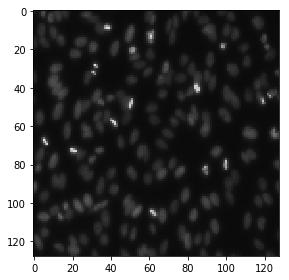

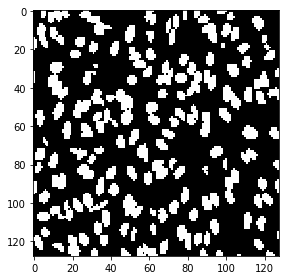

In [10]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [11]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [13]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/30
584/603 [============================>.] - ETA: 0s - loss: 0.5084 - mean_iou: 0.4205
Epoch 00001: val_loss improved from inf to 0.41817, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 3s 5ms/step - loss: 0.5062 - mean_iou: 0.4207 - val_loss: 0.4182 - val_mean_iou: 0.4241
Epoch 2/30
584/603 [============================>.] - ETA: 0s - loss: 0.3050 - mean_iou: 0.4234
Epoch 00002: val_loss improved from 0.41817 to 0.25198, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.3032 - mean_iou: 0.4234 - val_loss: 0.2520 - val_mean_iou: 0.4263
Epoch 3/30
584/603 [============================>.] - ETA: 0s - loss: 0.1727 - mean_iou: 0.4600
Epoch 00003: val_loss improved from 0.25198 to 0.17279, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.1714 - mean_iou: 0.4611 - val_loss: 0.1728 - val_mean_iou: 0.4

In [14]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 658us/step


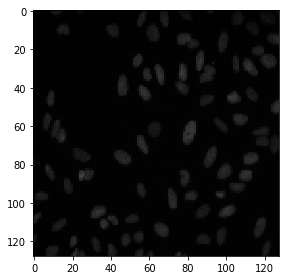

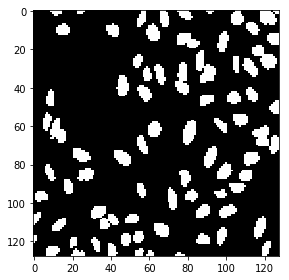

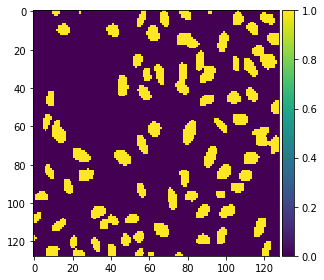

In [15]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

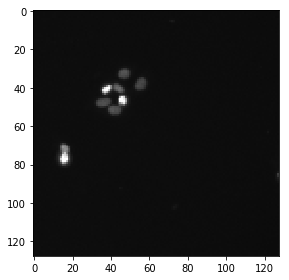

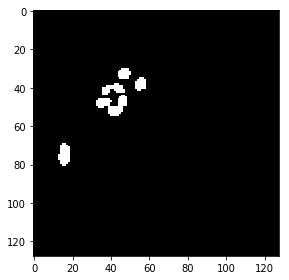

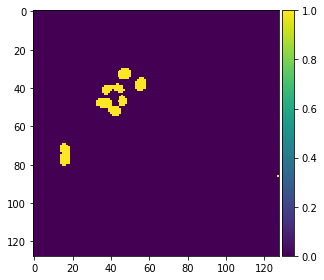

In [16]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [17]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [18]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [19]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

In [20]:
earlystopper = EarlyStopping(patience=100, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
584/603 [============================>.] - ETA: 0s - loss: 0.0728 - mean_iou: 0.8476
Epoch 00001: val_loss improved from inf to 0.09326, saving model to model-dsbowl2018-2.h5
603/603 [==============================] - 3s 4ms/step - loss: 0.0728 - mean_iou: 0.8480 - val_loss: 0.0933 - val_mean_iou: 0.8592
Epoch 2/100
584/603 [============================>.] - ETA: 0s - loss: 0.0703 - mean_iou: 0.8581
Epoch 00002: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0700 - mean_iou: 0.8582 - val_loss: 0.0970 - val_mean_iou: 0.8600
Epoch 3/100
584/603 [============================>.] - ETA: 0s - loss: 0.0696 - mean_iou: 0.8610
Epoch 00003: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0691 - mean_iou: 0.8610 - val_loss: 0.0988 - val_mean_iou: 0.8617
Epoch 4/100
584/603 [============================>.] - ETA: 0s - loss: 0.0694 - mean_iou: 0.8610
Epoch 00

Epoch 31/100
584/603 [============================>.] - ETA: 0s - loss: 0.0519 - mean_iou: 0.8719
Epoch 00031: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0519 - mean_iou: 0.8719 - val_loss: 0.0951 - val_mean_iou: 0.8723
Epoch 32/100
584/603 [============================>.] - ETA: 0s - loss: 0.0512 - mean_iou: 0.8726
Epoch 00032: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0513 - mean_iou: 0.8727 - val_loss: 0.0912 - val_mean_iou: 0.8729
Epoch 33/100
584/603 [============================>.] - ETA: 0s - loss: 0.0521 - mean_iou: 0.8732
Epoch 00033: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0518 - mean_iou: 0.8732 - val_loss: 0.0979 - val_mean_iou: 0.8735
Epoch 34/100
584/603 [============================>.] - ETA: 0s - loss: 0.0502 - mean_iou: 0.8738
Epoch 00034: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 

Epoch 62/100
584/603 [============================>.] - ETA: 0s - loss: 0.0314 - mean_iou: 0.8914
Epoch 00062: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0318 - mean_iou: 0.8914 - val_loss: 0.1213 - val_mean_iou: 0.8917
Epoch 63/100
584/603 [============================>.] - ETA: 0s - loss: 0.0324 - mean_iou: 0.8920
Epoch 00063: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0325 - mean_iou: 0.8920 - val_loss: 0.1237 - val_mean_iou: 0.8922
Epoch 64/100
584/603 [============================>.] - ETA: 0s - loss: 0.0332 - mean_iou: 0.8925
Epoch 00064: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0336 - mean_iou: 0.8925 - val_loss: 0.1192 - val_mean_iou: 0.8927
Epoch 65/100
584/603 [============================>.] - ETA: 0s - loss: 0.0341 - mean_iou: 0.8929
Epoch 00065: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 

Epoch 93/100
592/603 [============================>.] - ETA: 0s - loss: 0.0234 - mean_iou: 0.9050
Epoch 00093: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0234 - mean_iou: 0.9050 - val_loss: 0.1470 - val_mean_iou: 0.9052
Epoch 94/100
584/603 [============================>.] - ETA: 0s - loss: 0.0235 - mean_iou: 0.9054
Epoch 00094: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0238 - mean_iou: 0.9054 - val_loss: 0.1423 - val_mean_iou: 0.9056
Epoch 95/100
600/603 [============================>.] - ETA: 0s - loss: 0.0245 - mean_iou: 0.9057
Epoch 00095: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 0.0245 - mean_iou: 0.9057 - val_loss: 0.1438 - val_mean_iou: 0.9059
Epoch 96/100
600/603 [============================>.] - ETA: 0s - loss: 0.0244 - mean_iou: 0.9061
Epoch 00096: val_loss did not improve
603/603 [==============================] - 1s 2ms/step - loss: 

In [22]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-2.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-2.csv', index=False)    

65/65 [==============================] - 0s 421us/step
